In [3]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#import src.cleaning as cl

***src***

In [5]:
def downloading(path):
    """This function downloads from a raw link and saves the dataframe locally.
    args:
    :url: string. the link
    :name: string. name to save the file
    """
    
    df=pd.read_csv(path, encoding='latin')
    
    return df

In [6]:
df = downloading('data/attacks.csv')
df.sample()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
21295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def basic_cleaning(df):
    #modificamos todas las letras a minúsculas
    df=df.applymap(lambda x: x.lower() if type(x) == str else x)
    #modificamos los espacios blancos en los titulos de las las columnas por añadimos _
    df.columns = [i.lower().replace(" ", "_") for i in df.columns]
    #drops all rows from DataFrame "df" that contain all missing values (NaN)
    df = df.dropna(how='all')
    #eliminamos duplicados
    df= df.drop_duplicates()
    
    return df


In [8]:
df = basic_cleaning(df)
df.sample()

,case_number,date,year,type,country,area,location,activity,name,sex_,...,species_,investigator_or_source,pdf,href_formula,href,case_number.1,case_number.2,original_order,unnamed:_22,unnamed:_23
4288,1955.08.00.c,aug-1955,1955.0,unprovoked,north atlantic ocean,open sea,NaN,treading water,wolfgang emrich,m,...,NaN,"h.d.baldridge (1994), saf case #1489",1955.08.00.c-nv-emrich.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,1955.08.00.c,1955.08.00.c,2015.0,NaN,NaN


In [9]:
def cleaning_df1(df):
    
    #creates a copy of the principal df named df1
    #eliminamos las columnas indicadas del df1
    df.drop(['case_number', 'date', 'year', 'area', 'location', 'activity', 'name','investigator_or_source','pdf','href_formula', 'href', 'case_number.1', 'case_number.2', 'unnamed:_22','unnamed:_23' ], axis=1, inplace=True)
    ##creamos una copia de la columna species
    df['species2']=df['species_'].copy()
    #eliminamos todas las filas de las columnas indicadas con duplicados
    df.drop_duplicates() 
    #drops all rows from df1 that contain all missing values (NaN) in the specified subset of columns ('type', 'fatal_(y/n)', 'species2') and modifies the DataFrame in place.
    df.dropna(subset=['type', 'fatal_(y/n)', 'species2'], how='all', inplace=True)
    #rename some columns
    df.rename(columns={'species_': 'species', 'fatal_(y/n)':'fatality', 'sex_' : 'sex'}, inplace=True)
    
    return df

In [10]:
df =  cleaning_df1(df)
df.sample()

,type,country,sex,age,injury,fatality,time,species,original_order,species2
5152,unprovoked,usa,f,NaN,right leg bitten thigh to heel,n,17h30,"according to carlsmith, the shark's mouth was ...",1151.0,"according to carlsmith, the shark's mouth was ..."


In [11]:
def cleaning_df3(df):
      
    # Eliminar las filas con valores NaN en la columna species2
    df.dropna(subset=['species2'], how='all', inplace=True)
    
    #It searches for any numeric character (\d) followed by an optional character (.) and removes it
    df['species2']=df['species2'].apply(lambda x: re.sub(r'\d.?', '', x, flags=re.IGNORECASE))
    
    #deletting anything that's not a letter
    df['species2'] = df['species2'].apply(lambda x: re.sub(r'\W+', ' ', x))
    
    return df 

In [12]:
df = cleaning_df3(df)
df.sample()

,type,country,sex,age,injury,fatality,time,species,original_order,species2
461,unprovoked,south africa,m,15,"lacerations to lower left leg, puncture wounds...",n,08h00,"raggedtooth shark, 1.3 m",5842.0,raggedtooth shark m


In [13]:
def species_cleaning(df):
    
    #removes the letters 'm' and 'a' if they are found out of words.
    df['species2'] = df['species2'].str.replace(r'\s[m|a]\s', ' ', regex=True)
    df['species2'] = df['species2'].str.replace(r'^m|a\s', '', regex=True)
    df['species2'] = df['species2'].str.replace(r'\sm|as$', '', regex=True)
    
    #drops rows from df where the value in the 'species2' column is equal to any string in the "not_involved" list.
    not_involved= ['Shark involvement prior to death unconfirmed', 'Shark involvement prior to death not confirmed', 'Shark involvement suspected but not confirmed', 'Invalid', 'shark involvement not confirmed']
    for case in not_involved:
        df.drop(df[df['species2'] == case].index)
    
    #creamos un diccionario con los tipos de especies y los valores con los que aparece en el dataset
    species_dict={'white shark': 'white shark|whites', 
                  'nurse shark': 'nurse|nurses',
                  'tiger shark': 'tiger|tigers',
                  'grey reef shark': 'grey|greys|gray',
                  'wobbegong shark':'wobbegong|wobbegongs',
                  'bull shark': 'bull|bulls',
                  'blacktip shark': 'blacktip|blacktips|black tipped',
                  'hammerhead shark': 'hammerhead|hammerheads', 
                  'mako shark': 'Mako|Makos',
                  'mako shark': 'ako|Akos',
                  'lemon shark': 'lemon|lemons',
                  'largeako shark': 'largeako|largeakos', 
                  'oceanic whitetip shark': 'oceanic whitetip|oceanic whitetips', 
                  'whitetip reef shark':'whtietip|white tipped|whitetip reef',
                  'bronze whaler shark': 'bronze whaler|bronze whalers|bronze whale|Copper', 
                  'spinner shark': 'spinner|spinners',                 
                  'caribbean reef shark' : 'caribbean reef|caribbean reefs',                  
                  'blue shark' : 'blue pointer|blue pointers', 
                  'blue shark' : 'blue shark|blue sharks',
                  'blue shark' : 'blue nose',
                  'sandbar shark': 'brown|brown sharks',
                  'sandbar shark': 'sand|sandbar',
                  'bull shark': 'zambezi|zambesi', 
                  'raggedtooth shark': 'raggedtooth',
                  'dog fish shark': 'dog|dogfish',                
                  'unidentified shark' : 'unidentified|unknown'
                 }
    
    # Itera sobre cada elemento de la columna species2 del dataframe y reemplaza los valores
    for key, value in species_dict.items():
        mask= df['species2'].str.contains(value, case=False)
        df.loc[mask, 'species2'] = key


    #modificamos las celdas donde aparece una especie
    for specie, word in species_dict.items():   
        df.loc[df['species2'].str.contains(word, case=False), 'species2'] = specie
    
    
    #keeps only the words with more than two characters and then joins them back together with spaces
    df['species2'] = df['species2'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    
    
    
    return df

In [14]:
df = species_cleaning(df)
df.sample()

,type,country,sex,age,injury,fatality,time,species,original_order,species2
3089,unprovoked,australia,m,18,leg bitten,n,NaN,"""a small shark""",3214.0,small shark


In [15]:
def type_species_cleaning(df):

    #drops rows from df where the value in the 'type' column is equal to 'invalid', and modifies the df3.
    df.drop(df[df['type'] =='invalid'].index, inplace=True)
    
    #we eliminate rows with species2 column with Nan 
    df.dropna(subset=['species2'], how='all', inplace=True)
    
    #we remove the unique values that have less than 6 elements on the species2 column in df
    species_counts= {}
    for i,x in df['species2'].value_counts().items():
        species_counts[i]=x
        
    new_dict = {}
        
    for key, value in species_counts.items():
        if type(value) == int:
            if value >= 6:
                new_dict[key] = value

    
    #we remove those unique values that are not shark species
    species_list = list(new_dict.keys())
    species_list.remove('')
    species_list.remove('sharks')
    
    
    df = df[df['species2'].isin(species_list)]
    
    
    df.drop(['age', 'time'], axis=1, inplace=True)

    return df

In [16]:
df = type_species_cleaning(df)
df.sample()

C:\Users\pagob\AppData\Local\Temp\ipykernel_16724\4231477290.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['age', 'time'], axis=1, inplace=True)


,type,country,sex,injury,fatality,species,original_order,species2
3591,sea disaster,columbia,NaN,"10 survived, 51 perished.",y,shark involvement not confirmed,2712.0,shark involvement not confirmed


In [17]:
def fatality_sex_cleaning(df):
    #modificamos los datos de la columna fatality
    mask_unknown = (df['fatality'] == '2017')
    
    # Reemplazar las palabras en las filas seleccionadas
    df.loc[mask_unknown, 'fatality'] = 'unknown'
    
    #modificamos los datos de la columna fatality
    mask_no = (df['fatality'] == ' n')
    
    # Reemplazar las palabras en las filas seleccionadas
    df.loc[mask_no, 'fatality'] = 'n'
    
    #modificamos los datos de la columna fatality
    mask_unknown2 = (df['fatality'] == 'm')
    
    # Reemplazar las palabras en las filas seleccionadas
    df.loc[mask_unknown2, 'fatality'] = 'unknown'
    
    df['sex']=df['sex'].str.replace(r'm\s', 'm', regex=True)
    df['sex']=df['sex'].str.replace(r'n', 'unknown', regex=True)
    df['sex']=df['sex'].str.replace(r'lli', 'unknown', regex=True)
    
    return df

In [18]:
df = fatality_sex_cleaning(df)
df.sample()

,type,country,sex,injury,fatality,species,original_order,species2
2309,unprovoked,australia,f,puncture wounds on leg,n,wobbegong shark,3994.0,wobbegong shark


In [19]:
def visualization_cleaning(df):
    #creamos un df con la variable especies y fatality
    df = df.loc[:, ['species2', 'fatality']]
    df.rename(columns={'species2': 'species'}, inplace=True)
    
    #modificamos los datos de la columna fatality por integers
    no_fatality = (df['fatality'] == 'n')
    # Reemplazar las palabras en las filas seleccionadas
    df.loc[no_fatality, 'fatality'] = 0
    
    #modificamos los datos de la columna fatality por integers
    yes_fatality = (df['fatality'] == 'y')
    # Reemplazar las palabras en las filas seleccionadas
    df.loc[yes_fatality, 'fatality'] = 1
    
    return df

In [20]:
df = visualization_cleaning(df)
df.sample()

,species,fatality
3243,bronze whaler shark,0


In [21]:
def visualization1(df):
    
    sns.histplot(x=df['species'])
    plt.xticks(rotation=90)
    plt.title('Shark species vs number of attacks')
    plt.xlabel('shark species')
    plt.ylabel('attacks')

    plt.show()

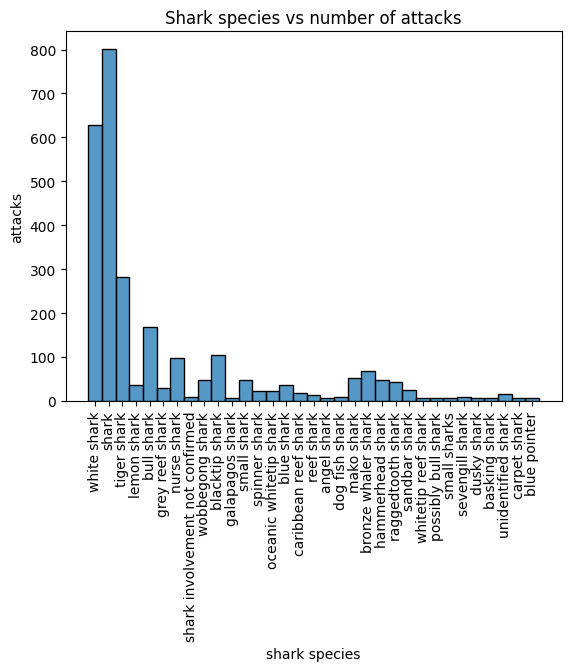

In [22]:
visualization1(df)

In [23]:
def visualization2(df):
    sharks = df["species"].value_counts()
    sharks.plot.pie(autopct="%.1f%%");
    plt.show()

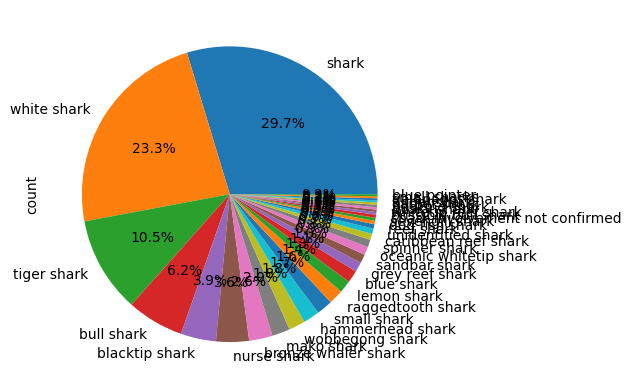

In [24]:
visualization2(df)

In [25]:
def visualization3(df):
    sns.histplot(data=df, x="species", hue="fatality", multiple="stack");
    plt.xticks(rotation=90);
    plt.title('Shark species vs number of attacks and fatality')
    plt.xlabel('shark species')
    plt.ylabel('attacks');
    plt.show()

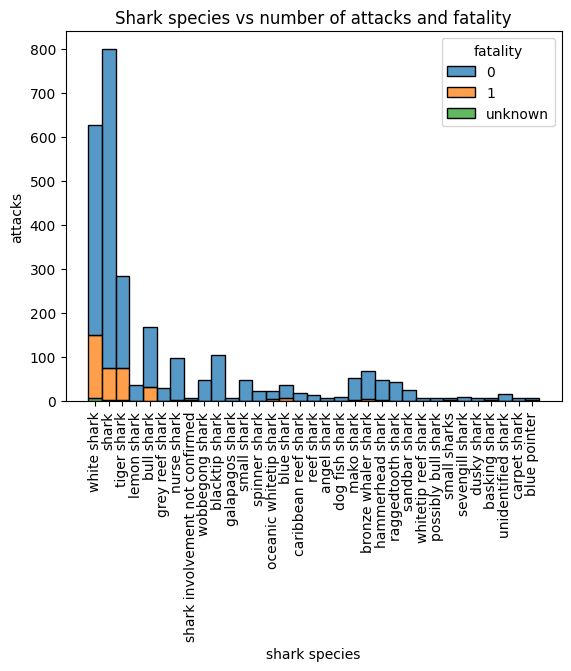

In [26]:
visualization3(df)

In [27]:
#df.dropna(subset=['species2'], how='all', inplace=True)

***DATAFRAME***